# Librerías 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import joblib
import os

In [17]:
ruta_dataset = os.path.join("..", "data", "raw", "Telco_churn.csv")
df = pd.read_csv(ruta_dataset)

Los modelos de Regresión Lineal son altamente sensibles a las multicolinealidades, por ello, he decidido reducir el conjunto de variables y quedarme solo con aquellas que:

- Tienen mayor correlación con el target (Churn)

- No están altamente correlacionadas entre sí

La columnas con las que nos quedaremos para entrenar nuestro modelo serán: SeniorCitizen, Dependents,
tenure, PaperlessBilling, PaymentMethod, MonthlyCharges y Churn.

| Variable           | Tipo               | Descripción                             |
| ------------------ | ------------------ | --------------------------------------- |
| `SeniorCitizen`    | Binaria (0/1)      | 0 = No es senior, 1 = Es senior         |
| `Dependents`       | Binaria (Yes/No)   | Tiene dependientes o no                 |
| `tenure`           | Numérica discreta  | Meses como cliente                      |
| `PaperlessBilling` | Binaria (Yes/No)   | Si usa facturación electrónica          |
| `PaymentMethod`    | Categórica nominal | Método de pago elegido                  |
| `MonthlyCharges`   | Numérica continua  | Cargo mensual del cliente               |
| `Churn`            | Binaria (Yes/No)   | Si abandonó el servicio o no *(target)* |


Para el paso siguiente se tendrá que:

Codificar las variables binarias en 0 y 1
Escalar las numéricas para evitar la diferencia de comparar distintos items en una misma métrica

# Feature engineering

Nuestro dataset incluye diferentes tipos de features por lo cual cada una de ella necesita tener diferente transformación y preprocesado para poder entrenar el modelo. Inicialmente vamos a definir estas features para posteriormente poderlas añadir a un pipeline de procesado y modelaje.

### Definir tipo de variables

In [18]:
numeric_cols = ['tenure', 'MonthlyCharges']
binary_cols = ['Dependents', 'PaperlessBilling', 'SeniorCitizen']  # agregada SeniorCitizen
categorical_cols = ['PaymentMethod']

### Guardamos el Id de cliente

In [19]:
customer_ids = df['customerID']

### División del dataset para aprendizaje

In [20]:
X = df.drop(columns='Churn')
y = df['Churn'].map({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids, test_size=0.3, random_state=42, stratify=y
)

### Definimos los preprocesadores

In [21]:
# Preprocesamos cada una de las variables según su tipo
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),                            # Escalar numéricas         
    ('bin', OneHotEncoder(drop='if_binary'), binary_cols),              # Codificar binarias           
    ('cat', OneHotEncoder(drop='first'), categorical_cols)              # Codificar categóricas  
], remainder='drop')  # mejor quitar columnas que no proceses para evitar problemas

### Logistic Regression

In [22]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(class_weight='balanced',max_iter=1000))
])

### Creamos los parametros para el GSCV

In [23]:
# Define los parámetros que quieres probar
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],         # Ten en cuenta que algunos solvers no soportan l1
    'model__solver': ['liblinear', 'saga'], # liblinear funciona bien para l1/l2 en problemas pequeños
}

In [24]:
# Crea el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)

# Entreno de modelo LogisticRegression

In [25]:
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear', 'saga']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('bin', ...), ...]"


In [26]:
# Mejor modelo y mejor score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor Recall:", grid_search.best_score_)

# Predicciones con mejor modelo
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:,1]

Mejores parámetros: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Mejor Recall: 0.791293030329619


# Evaluación del modelo

Matriz de Confusión:
[[1057  495]
 [ 124  437]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      1552
           1       0.47      0.78      0.59       561

    accuracy                           0.71      2113
   macro avg       0.68      0.73      0.68      2113
weighted avg       0.78      0.71      0.72      2113


AUC-ROC: 0.816


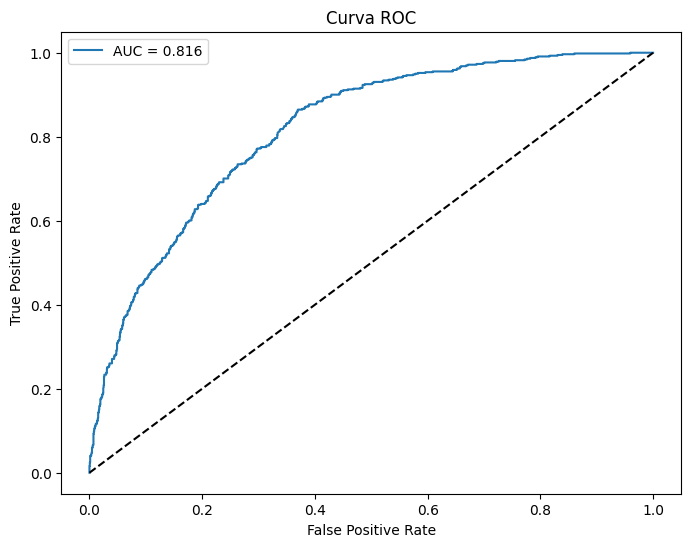

In [27]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Reporte de clasificación (Precision, Recall, F1)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
auc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [29]:
ruta_reg_log = r"C:\Users\Merche\REPOSITORIO_MI_PORTFOLIO\Predictor de Churn\ML\models\modelo_Reg_Log.joblib"
joblib.dump(grid_search, ruta_reg_log )

['C:\\Users\\Merche\\REPOSITORIO_MI_PORTFOLIO\\Predictor de Churn\\ML\\models\\modelo_Reg_Log.joblib']

# Post-procesado : Mejorando el modelo 

In [ ]:
# Obtener las probabilidades de clase positiva (churn)
y_proba = grid_search.predict_proba(X_test)[:,1]

# Cambiar el umbral (ej. 0.4 en lugar de 0.5)
threshold = 0.4
y_pred_threshold = (y_proba >= threshold).astype(int)

# Matriz de Confusión
cm = confusion_matrix(y_test.astype(int), y_pred_threshold)
print("Matriz de Confusión con threshold =", threshold)
print(cm)

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test.astype(int), y_pred_threshold))

# AUC (no cambia con el threshold)
auc = roc_auc_score(y_test.astype(int), y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

Matriz de Confusión con threshold = 0.4
[[825 727]
 [ 49 512]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68      1552
           1       0.41      0.91      0.57       561

    accuracy                           0.63      2113
   macro avg       0.68      0.72      0.62      2113
weighted avg       0.80      0.63      0.65      2113


AUC-ROC: 0.816


Al cambiar el umbral, el recall mejora pero la precisión empeora. Esto significa que el modelo predice mejor a los que se va pero peor a los que realmente no se iban a ir y el modelo entiende que si. 